In [78]:
import numpy as np
import pandas as pd
import requests
from hmmlearn import hmm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from dateutil import parser
from matplotlib.collections import LineCollection
from itertools import product, zip_longest

In [2]:
api_key = "b69eaad26ff420f24653c4f0cdfd02d6"

url = "http://api.eia.gov/series/?api_key=b69eaad26ff420f24653c4f0cdfd02d6&series_id=EBA.CAL-ALL.D.H".format(api_key)

response = requests.get(url)
response.json()
data_CA = pd.DataFrame(response.json()['series'][0]['data'])

In [79]:
api_key = "b69eaad26ff420f24653c4f0cdfd02d6"

series_id = 'SEDS.TETCB.NY.A'
'EBA.NY-ALL.D.H'

url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.H".format(api_key)

response = requests.get(url)
response.json()
data_arr = np.asarray(response.json()['series'][0]['data'])
dt_list = []
for i in range(len(data_arr)):
    dt_list.append(parser.parse(data_arr[i][0]))
# Format data so that it has a datetime index
data_arr = np.asarray(response.json()['series'][0]['data'])
dt_list = []
for i in range(len(data_arr)):
    dt_list.append(parser.parse(data_arr[i][0]))
data_NY = pd.DataFrame(data=data_arr[:,1], index=dt_list)

# Prep the demand column
data_NY.columns = ['demand']
data_NY.demand = pd.to_numeric(data_NY.demand)

# Clean data to replace zeros as missing
data_NY.demand = data_NY.demand.replace(0,np.nan).interpolate()

In [80]:
#start_date = datetime(2015,7,1,5)
train_start_dt = dt_list[-1]
train_end_dt = dt_list[360*24]
if train_end_dt.day != 30:
    add_days = ((30 - train_end_dt.day)*24)
    train_end_dt = dt_list[(360*24)-add_days]
if train_end_dt.hour != 23:
    add_days += 23-train_end_dt.hour
    train_end_dt = dt_list[(360*24)-add_days]
test_start_dt = dt_list[(360*24)-add_days-1]
print('train_end:',train_end_dt,'test_start:',test_start_dt)
#test_start_dt = datetime(2018,11,1,0,tzinfo=utc)
#train_start_dt, train_end_dt, test_start_dt

train_end: 2018-11-30 23:00:00+00:00 test_start: 2018-12-01 00:00:00+00:00


In [69]:
times = pd.DatetimeIndex(data_NY.index)
data_NY.groupby([times.year]).sum()

,demand
2015,82366342
2016,160796681
2017,156349038
2018,161135062
2019,133137809


In [81]:
data = data_NY.loc[train_end_dt:train_start_dt]
test = data_NY.loc[data_NY.index[0]:test_start_dt]
n=len(test)

In [82]:
#transform data to fit hierarchical HMMs
train_dict = {}
#create daily
times = pd.DatetimeIndex(data.index)
#df.groupby(times.hour)
#data.loc[data_NY.index[0]:data_NY.index[50]].groupby(times.hour).mean()
train_dict['hour'] = data.groupby([times.day,times.hour]).sum().values

#create weekly
train_dict['day'] = data.groupby([times.month,times.day]).sum().values

#create monthly
train_dict['month'] = data.groupby([times.year,times.month]).sum().values

test_dict = {}
#create daily
times = pd.DatetimeIndex(test.index)
#df.groupby(times.hour)
#data.loc[data_NY.index[0]:data_NY.index[50]].groupby(times.hour).mean()
test_dict['hour'] = test.groupby([times.day,times.hour]).sum().values

#create weekly
test_dict['day'] = test.groupby([times.month,times.day]).sum().values

#create monthly
#drop final month because it is a partial
times = pd.DatetimeIndex(test.index)
test_dict['month'] = (test.groupby([times.year,times.month]).sum().values)[0:12]
#label = test_dict['month'].index[12]
#test_dict['month'].drop(label,inplace=True)

In [83]:
#create HMM for each group
hmm_dict = {}
hmm_list = ['hour','day','month']
hmm_states = [5,10,12,24,34,48,100]
#hmm_idx = zip_longest(hmm_list,hmm_states)
hmm_idx = product(hmm_list,hmm_states)
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
for i in hmm_idx:
    print(i)
    model = hmm.GaussianHMM(n_components=i[1],n_iter=10)
    model.fit(train_dict[i[0]])
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test_dict[i[0]])
    states_dict[i] = model.predict(train_dict[i[0]])
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)

('hour', 5)
('hour', 10)
('hour', 12)
('hour', 24)
('hour', 34)
('hour', 48)
('hour', 100)
('day', 5)
('day', 10)
('day', 12)
('day', 24)
('day', 34)
('day', 48)
('day', 100)
('month', 5)
('month', 10)
('month', 12)
('month', 24)
('month', 34)
('month', 48)


ValueError: n_samples=41 should be >= n_clusters=48

In [84]:
score_dict

{('hour', 5): -17297.18777897842,
 ('hour', 10): -17345.194895444838,
 ('hour', 12): -17185.475271374853,
 ('hour', 24): -19393.504849249635,
 ('hour', 34): -19928.674350476893,
 ('hour', 48): -21049.666297313535,
 ('hour', 100): -19156.57075630858,
 ('day', 5): -8151.865887054504,
 ('day', 10): -27116.10425531517,
 ('day', 12): -33854.657837354556,
 ('day', 24): -33961.17130583066,
 ('day', 34): -33548.58985831112,
 ('day', 48): -33256.9053228787,
 ('day', 100): -29905.736140620706,
 ('month', 5): -347.73921245277205,
 ('month', 10): -310.9161149297373,
 ('month', 12): -336.0322825068959,
 ('month', 24): -309.660394982068,
 ('month', 34): -301.5892157095116}

In [158]:
for i in range(99,100):
    model = hmm.GaussianHMM(n_components=i,n_iter=10)
    model.fit(data)
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test)
    states_dict[i] = model.predict(data)
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)

In [159]:
score_dict

{3: -76609.1839334813,
 4: -74778.92654827525,
 5: -73669.14186576444,
 99: -70336.2154866844}

In [71]:
st_mu = np.zeros(len(states_dict[4]))
st_mu = np.where(states_dict[4]==0,means_dict[4][0],np.where(states_dict[4]==1,means_dict[4][1],np.where(states_dict[4]==2,means_dict[4][2],means_dict[4][3])))

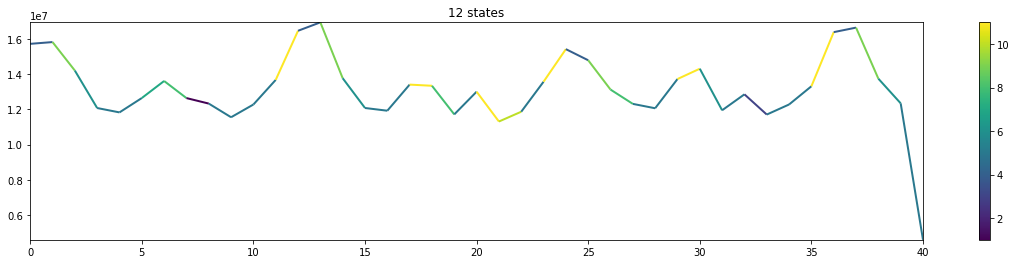

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = len(train_dict['month'])
x = np.arange(end)
y = train_dict['month'].ravel()
st = states_dict['month']

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [19]:
sample_x_dict.keys()

dict_keys(['hour', 'day', 'month'])

KeyError: 'month'

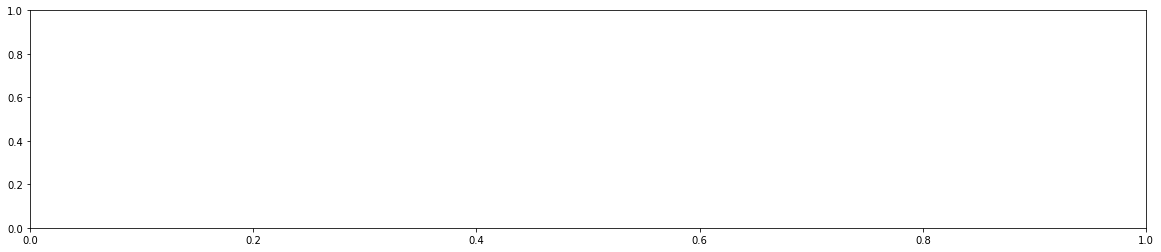

In [88]:
#sample from monthly model and compare to test
i  = 'month'
st=0
end=12
off = 7
fig ,ax = plt.subplots(figsize=(20,4), sharex=True, sharey=True)
x = np.arange(end)
for offset in range(off,off*5,12):    
    ax.plot(x, sample_x_dict[i][st+offset:end+offset])
ax.plot(x, test_dict[i][st:end],c='black')
ax.set_xlim(x.min(), x.max())
ax.set_ylim((sample_x_dict[i].min()-100), sample_x_dict[i].max()+100)
plt.show()

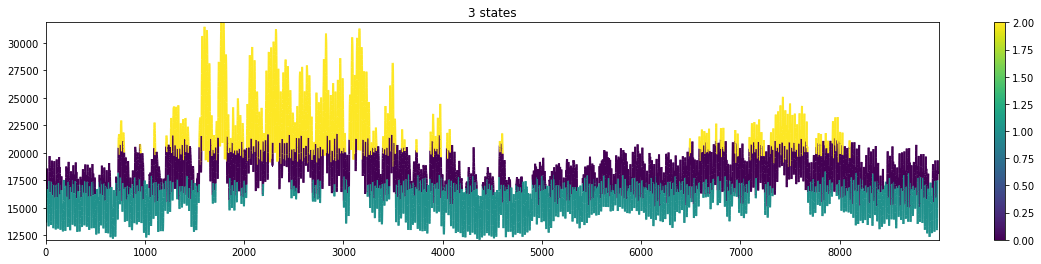

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = n
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = states_dict[3][st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

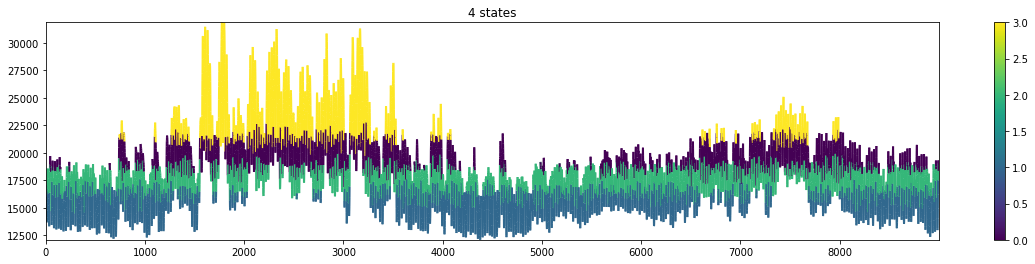

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = 9000
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = states_dict[4][st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

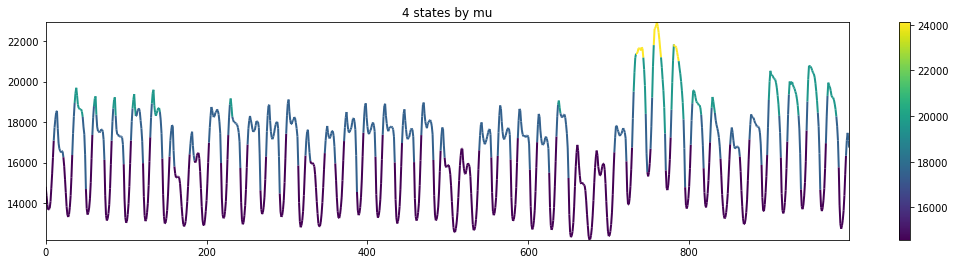

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = 1000
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = st_mu[st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(18, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title('4 states by mu')
plt.show()

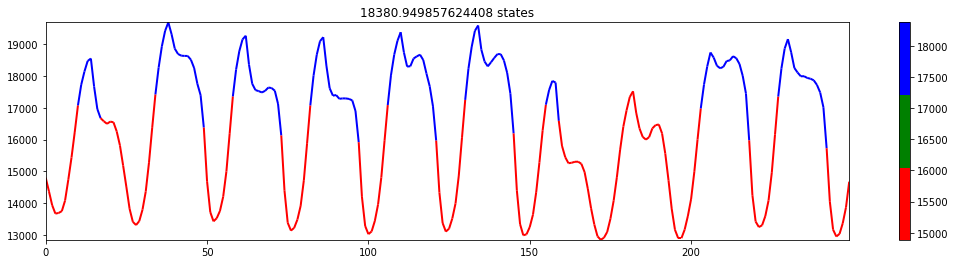

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = 250
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
#st = states_dict[3][st:end] 
st = st_mu[st:end]

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(18, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
cmap = ListedColormap(['r', 'g', 'b'])
lc = LineCollection(segments, cmap=cmap)
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [124]:
len(test),n

(1, 8640)

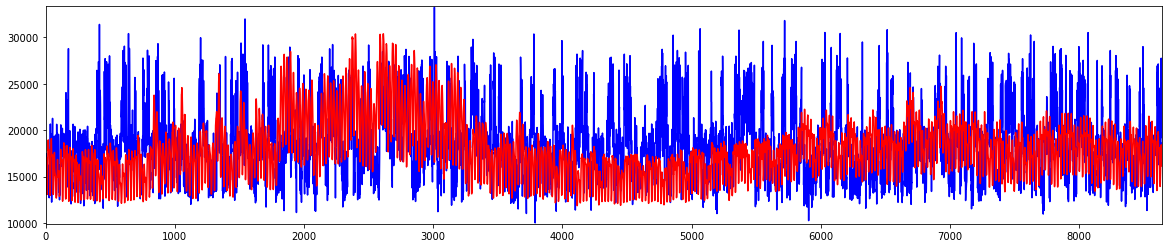

In [135]:
#sample from model 3 and compare to test
i  = 3
fig ,ax = plt.subplots(figsize=(20,4), sharex=True, sharey=True)
x = np.arange(n)
ax.plot(x, sample_x_dict[i],c='b')
ax.plot(x, test,c='r')
ax.set_xlim(x.min(), x.max())
ax.set_ylim((sample_x_dict[i].min()-100), sample_x_dict[i].max()+100)
plt.show()

In [ ]:
#sample from model 13 and compare to test

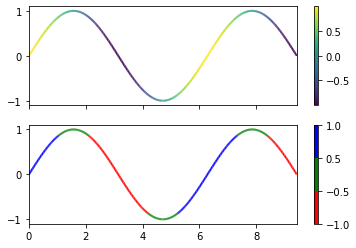

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

In [118]:
from hmmlearn.hmm import MultinomialHMM
data = data_NY.loc[train_end_dt:train_start_dt]
test = data_NY.loc[test_start_dt].to_numpy().reshape(-1,1)
mult_conv_dict = {}
mult_score_dict = {}
mult_states_dict = {}
mult_means_dict = {}
mult_covars_dict = {}
for i in range(14,30):
    model = hmm.MultinomialHMM(n_components=i,n_iter=10)
    model.fit(data)
    mult_conv_dict[i] = model.monitor_.converged
    mult_score_dict[i] = model.score(test)
    mult_states_dict[i] = model.predict(data)
    mult_means_dict[i] = model.means_
    mult_covars_dict[i] = model.covars_

ValueError: expected a sample from a Multinomial distribution.